# FINM 33150 Homework 5: FX Carry Strategy

Sean Lin

Student ID: 12375235

***

## 1 Introduction

In this assignment, we create an FX carry trade with British Pounds and currencies from Eastern Asia. An FX carry strategy borrows a low interest-rate currency and uses it to fund a position in a high interest-rate currency, typically via a cross-currency swap. We examine the performance of the strategy with all the different currencies and then look further into characteristics of FX carry strategies and whether we see them here.

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns
import statsmodels.api as sm

import quandl 

warnings.filterwarnings('ignore')

In [2]:
KEY = os.getenv('QUANDL_KEY')
quandl.ApiConfig.api_key = KEY # Insert your key here if you want to run the code yourself 

# 2 Data

We obtained 1M (0.08 Y) rates for UK overnight index swaps, and yield curves of Vietnamese Dong, Thai Baht, Pakistani Rupee, and Philippine Peso as well as FX rates converting from USD to these currencies. With these curves, we create zero coupon curves in order to price bonds at any time. We also filter our data such that we only have the relevant components.

***

**2.1 UK Overnight Index Swaps and FX Rates**

These UK Overnight Index Swaps were obtained from the Quandl database and were given in annualized rates. We used `YC/GBR/ISSC` and `YC/GBR_ISSS` to form our OIS rates. Both were used as the data is not complete and we need both datasets in order to create a full sample.

In [3]:
ISSC = quandl.get('YC/GBR_ISSC', returns='pandas') / 100 
ISSS = quandl.get('YC/GBR_ISSS', returns='pandas') / 100

new_index = ISSC.index.union(ISSS.index)
OIS = ISSC.reindex(new_index)
OIS = OIS.combine_first(ISSS)

START_DATE = str(OIS.index[0]) # Since we always need these swap rates, all our trades will begin from here at a minimum 
END_DATE = str(OIS.index[-1]) # We also cannot trade after this date as we will not have any data 

We then import all the FX rates utilizing the `CUR` database in Quandl.

In [4]:
currencies = ['GBP','VND','THB','PKR','PHP']
FXRATES = pd.DataFrame()
for c in currencies:
    FXRATES['USD' + c] = quandl.get('CUR/' + c,start_date=START_DATE,end_date=END_DATE,returns='pandas')

***

**2.2 Yield Curves**

We now import the yield curves for the currencies by using the `YC` quandl database. We only obtain data within the range of our start and end date (defined above). Since there may be missing values (due to discrepencies in holidays), we also fill in missing values by using a linear interpolation. We also filter our data so that we only have yields that are greater than or equal to 1Y. Later, we will use these yield curves to create zero-coupon curves and this helps prevent *weird* values later on.

In [5]:
VNDYIELD = quandl.get('YC/VNM',start_date=START_DATE,end_date=END_DATE,returns='pandas') / 100 
THBYIELD = quandl.get('YC/THA',start_date=START_DATE,end_date=END_DATE,returns='pandas') / 100 
PKRYIELD = quandl.get('YC/PAK',start_date=START_DATE,end_date=END_DATE,returns='pandas') / 100 
PHPYIELD = quandl.get('YC/PHL',start_date=START_DATE,end_date=END_DATE,returns='pandas') / 100

VNDYIELD.columns = [1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
THBYIELD.columns = [1/12, 1/4, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
PKRYIELD.columns = [1/4, 1/2, 1, 3, 5, 10]
PHPYIELD.columns = [1/12, 1/4, 1/2, 1, 2, 3, 4, 5, 7, 10, 20, 25]

VNDYIELD.interpolate(method='linear',axis=0,inplace=True) # Interpolation 
THBYIELD.interpolate(method='linear',axis=0,inplace=True)
PKRYIELD.interpolate(method='linear',axis=0,inplace=True)
PHPYIELD.interpolate(method='linear',axis=0,inplace=True)

VNDYIELD = VNDYIELD.T[VNDYIELD.T.index >= 1].T # Only keeping yields greater than or equal to 1 
THBYIELD = THBYIELD.T[THBYIELD.T.index >= 1].T
PKRYIELD = PKRYIELD.T[PKRYIELD.T.index >= 1].T 
PHPYIELD = PHPYIELD.T[PHPYIELD.T.index >= 1].T

***

**2.3 Viewing the Data**

This is all the data we need to actually simulate our FX carry trade. As is good practice, we will look at all the data we just imported.

*2.3.1 UK Overnight Index Swaps*

Text(0, 0.5, 'Swap Rate')

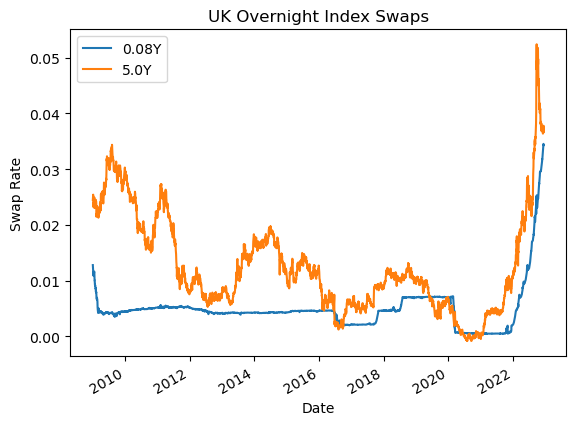

In [6]:
OIS[['0.08Y','5.0Y']].plot(title='UK Overnight Index Swaps')
plt.ylabel('Swap Rate')

In [7]:
OIS[['0.08Y','5.0Y']].describe().loc[['min','max']]

,0.08Y,5.0Y
min,0.000393,-0.000826
max,0.034547,0.052415


We see that the 5Y swap rate was decreasing throughout the last decade before quickly increasing. This is likely due to recent rate hikes by the Bank of England. For the 0.08Y swap rate, we see that it remains relatively flat before going negative, likely due to the pandemic. 

*2.3.2 Yield Curves*

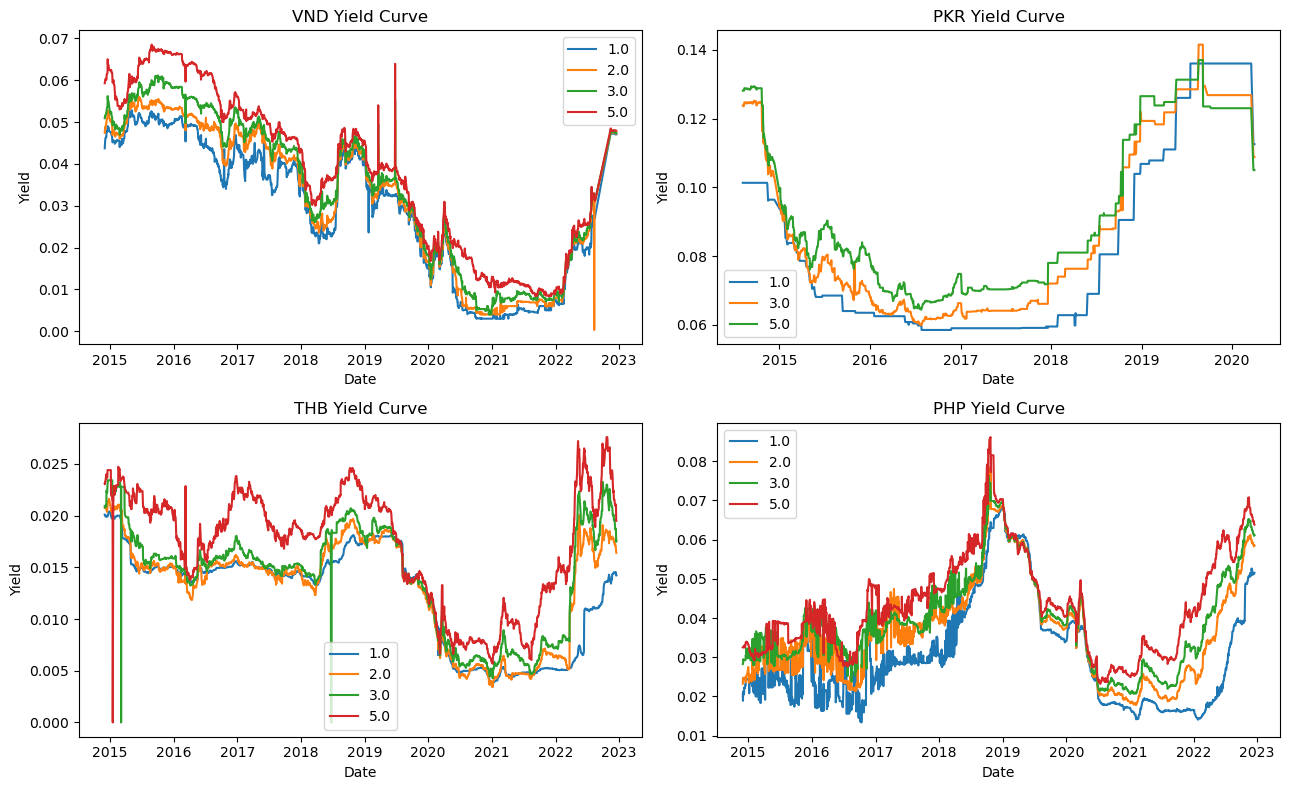

In [8]:
fig, axes = plt.subplots(2,2,figsize=(13,8))
axes[0,0].plot(VNDYIELD[[1.0,2.0,3.0,5.0]],label=[1.0,2.0,3.0,5.0])
axes[0,0].set_title('VND Yield Curve')

axes[1,0].plot(THBYIELD[[1.0,2.0,3.0,5.0]],label=[1.0,2.0,3.0,5.0])
axes[1,0].set_title('THB Yield Curve')

axes[0,1].plot(PKRYIELD[[1.0,3.0,5.0]],label=[1.0,3.0,5.0])
axes[0,1].set_title('PKR Yield Curve')

axes[1,1].plot(PHPYIELD[[1.0,2.0,3.0,5.0]],label=[1.0,2.0,3.0,5.0])
axes[1,1].set_title('PHP Yield Curve')

for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Yield')

plt.tight_layout()

Here, we plot the 1, 2, 3, and 5Y yield curves (when available). We see that for the most part, interest rates have been rising in all four countries in the last couple years. Before then, the they looked to be less correlated. We also see that the yield curve of PKR was recently inverted (1Y having a higher yield than 5Y).

*2.3.3 FX rates*

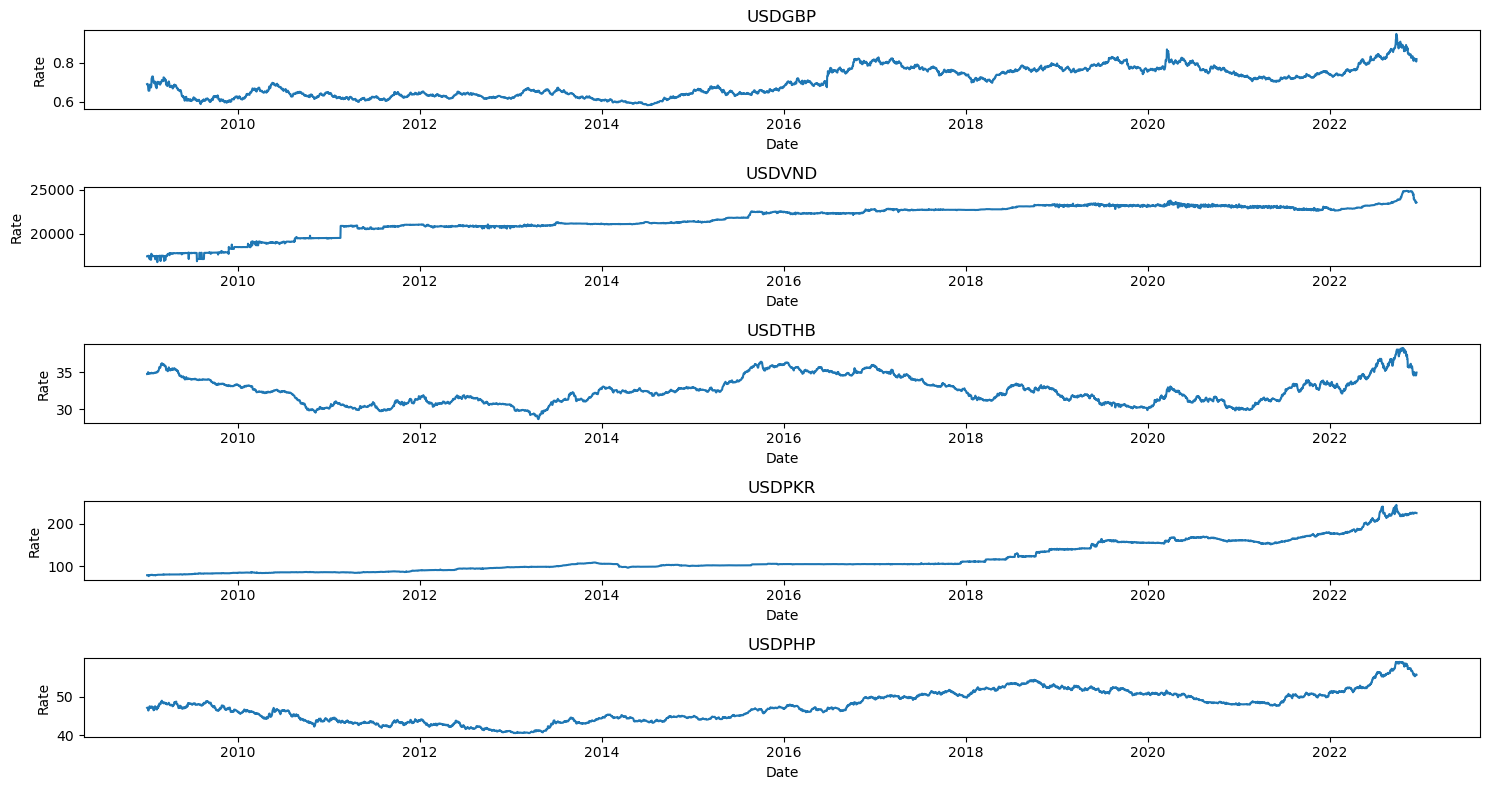

In [9]:
fig, axes = plt.subplots(5,1,figsize=(15,8))
for i, col in enumerate(FXRATES.columns):
    axes[i].plot(FXRATES[col])
    axes[i].set_title(col)
    axes[i].set_ylabel('Rate')
    axes[i].set_xlabel('Date')

plt.tight_layout()

Here we see that the volatility of FX rates isn't particularly high. They tend to stay within some type of range. We will now examine the correlations of daily returns.

<AxesSubplot: >

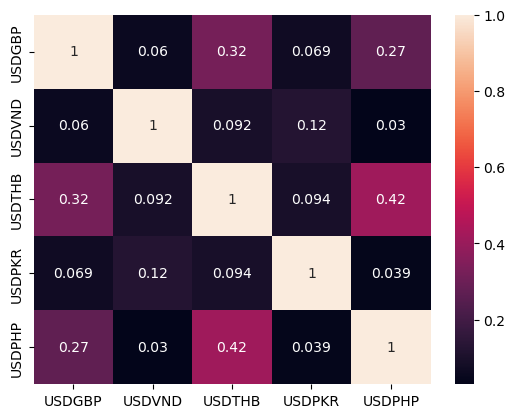

In [10]:
sns.heatmap(FXRATES.pct_change().corr(), annot=True)

We see that the currencies have low correlations with each other. The highest correlation is between USDPHP and USDTHB with a correlation of 0.42. On the other hand, we see USDPHP/USDVND, USDPHP/USDPKR, USDGBP/USDVND having correlations of near zero.

***

# 3 FX Carry Simulation

In this section, we simulate our FX carry trade. We will calculate our PnL of our weekly-traded cross-currency fixed-float swaps utilizing the swap rates which are normalized to have USD values. Each week, we will begin with a $10 million USD notional to make bug tracking easier. We will first define two currencies: borrowing and lending. Our borrowing currency is the currency in which we are short and the lending currency is the currency in which we are long. Here, our borrowing currency will *always* be GBP while our lending currency will *always* be one of the East Asian currencies.

First, we will borrow $8 million USD worth of GBP by leveraging $2 million in USD (5x leverage). We will borrow this at a rate of OIS + 50bps. As a result, we will have $10 million in USD that we can buy Eastern Asian bonds with. We will convert $10 million USD into the other currency and buy X amount of bonds. We calculate the bond prices by utilizing the yield curves we obtained earlier. However, we will convert them into zero coupon bond curves in order to price anything. We will buy 5Y bonds. When buying these bonds, we will assume that it has a quarterly coupon rate at the 5Y swap rate. We will approximate the yield curves to be the swap curves when in reality, it is not the case. We will also only enter trades when the 5Y swap rate of the lending currency is more than 50bps higher than the 5Y swap rate of the borrowing currency (GBP). We will enter at the start of each week and exit at the end. 

To exit our position, we must sell our East Asian bonds at the rate offered. Since we are buying 5Y bonds, the time-until-maturity has decreased slightly and the rate has also shifted. We will reprice the bond and sell it at that price. We will then convert it back into USD, though now we need to repay our loan in GBP. Thus we must convert a portion of our position into the equivalent of the initial value in GBP, though we could either make or lose money on the FX rate change. We also need to pay the accrued interest on the borrowed money in GBP. 
***

**3.1 Helper Functions**

We will first define the helper functions `compute_zcb_curve`, `bond_price`, `simulate`, and `plot_decomposition`. Documentation on the functions can be found below.

In [11]:
def compute_zcb_curve(spot_rates_curve):
    '''
    Computes a zero-coupon bond curve from a spot curve 

    Parameters:
        spot_rates_curve (DataFrame): DataFrame of the spot curve 

    Returns:
        zcb_rates (DataFrame): DataFrame of the zero-coupon rates in the same format as the spot rate DataFrame  
    '''
    spot_rates_curve = spot_rates_curve.T
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_half_yr = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates.T

In [12]:
def bond_price(zcb, coupon_rate, tenor):
    '''
    Prices a bond given the zero-coupon-bond curve, coupon rate, and time-until-maturity

    Parameters:
        zcb (DataFrame): Zero-coupon bond curve 
        coupon_rate (float): Coupon rate (paid quarterly)
        tenor (float): Time until maturity for the bond

    Returns:
        p (float): The price of the bond
    '''
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p

In [72]:
def simulate(lending_yield,pair,borrow_yield=OIS,fxrates=FXRATES,notional=2_000_000,leverage=5,spread=True):
    '''
    Simulates the FX carry trade for a given currency 

    Parameters:
        lending_yield (DataFrame): DataFrame consisting of the yield curve for the lending country / currency 
        pair (string): The currency pair associated with the yield curve  
        borrow_yield (DataFrame): DataFrame consisting of the yield curve for the borrow country / currency (default OIS)
        fxrates (DataFrame): DataFrame consisting of the FX rates (default FXRATES)
        notional (float): Amount of capital you currently own (default 2_000_000)
        leverage (float): The leverage that you are trading on (default 5)
        spread (bool): Whether to consider the spread between 5Y rates (default True)

    Returns:
        pnls (DataFrame): DataFrame consisting of the weekly PnLs 
    '''
    zcb = compute_zcb_curve(lending_yield) 

    new_index = borrow_yield[(borrow_yield.index >= lending_yield.index[0]) & (borrow_yield.index <= lending_yield.index[-1])].index # Reindexing so that the dates align 
    borrow_yield = borrow_yield.loc[new_index]
    zcb = zcb.reindex(new_index).interpolate(method='linear',axis=0)
    lending_yield = lending_yield.reindex(new_index).interpolate(method='linear',axis=0)

    leverage_notional = notional * leverage # Calculating leverage requirements 
    leverage_ratio = 1 - notional/leverage_notional

    pnls = pd.DataFrame(columns=['Borrow PnL','Lending PnL','Interest','Total PnL'])
    for _, data in borrow_yield.groupby(new_index.to_period('W-TUE')):
        num_days = len(data)
        first_day = data.index[0] 
        last_day = data.index[-1]

        if num_days <= 2: # Conditions to not trade during a week 
            pnls.loc[last_day] = 0
            continue 

        if spread == True and lending_yield.loc[first_day, 5] - borrow_yield.loc[first_day, '5.0Y'] < 0.005:
            pnls.loc[last_day] = 0
            continue 
        
        # Borrow certain amount of GBP based on leverage requirements 
        borrowed_currency = leverage_ratio * leverage_notional * fxrates['USDGBP'].loc[first_day] # Borrowed currency in GBP
        interest_rate = borrow_yield['0.08Y'].loc[first_day] + 0.005 # Interest rate for the trade 

        lending_notional = leverage_notional * FXRATES[pair].loc[first_day] # Amount of foreign currency after converting from USD 
        lending_init_price = bond_price(zcb.loc[first_day],lending_yield.loc[first_day,5],5) # Pricing initial value of the foreign bond 
        lending_pos_size = lending_notional / lending_init_price # Position size 

        duration = (last_day - first_day).days / 365.25 # Duration elapsed during the trade 

        lending_final_price = bond_price(zcb.loc[last_day],lending_yield.loc[first_day,5],5-duration) # Pricing final value of the foreign bond 
        pos_final_value = lending_pos_size * lending_final_price 
        pos_final_val_usd = pos_final_value / FXRATES[pair].loc[last_day] # Converting back to USD 

        accrued_interest = borrowed_currency * (np.exp(interest_rate * duration) - 1) # Accrued interest in GBP 
        accrued_interest_usd = accrued_interest / FXRATES['USDGBP'].loc[last_day] # Converting accrued interest to USD 
        repayed_borrowed_usd = borrowed_currency / FXRATES['USDGBP'].loc[last_day] # Amount needed to repay in USD 

        lending_pnl = pos_final_val_usd - leverage_notional # PnL component from purchasing bonds and FX rates
        borrow_pnl = leverage_ratio * leverage_notional - repayed_borrowed_usd# PnL component from borrowing and FX rates 
        weekly_pnl = lending_pnl + borrow_pnl - accrued_interest_usd # Total PnL 
        pnls.loc[last_day] = [borrow_pnl,lending_pnl,-accrued_interest_usd,weekly_pnl]

    return pnls 

In [25]:
def plot_decomposition(pnl,name):
    '''
    Plots the PnL decomposition for a series 

    Parameters:
        pnl (DataFrame): DataFrame consisting of the PnLs for a period of time 
        name (string): Title of the plot 

    '''
    fig, ax = plt.subplots()
    pnl.plot(kind='bar',stacked=True,ax=ax,figsize=(18,5))

    xticks = np.arange(0, len(pnl.index), 52)
    xticklabels = [pnl.index[x].year for x in xticks]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_title(name)
    ax.set_xlabel('Date')
    ax.set_ylabel('PnL')

    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

***

**3.2 FX Carry Showcase**

Now that we have our functions defined, we will show how the FX carry trades play out for each of the currencies. We will decompose the total PnL into Borrow PnL, Lending PnL, and Interest. 

In [73]:
vnd = simulate(VNDYIELD,'USDVND')
thb = simulate(THBYIELD,'USDTHB')
pkr = simulate(PKRYIELD,'USDPKR')
php = simulate(PHPYIELD,'USDPHP')

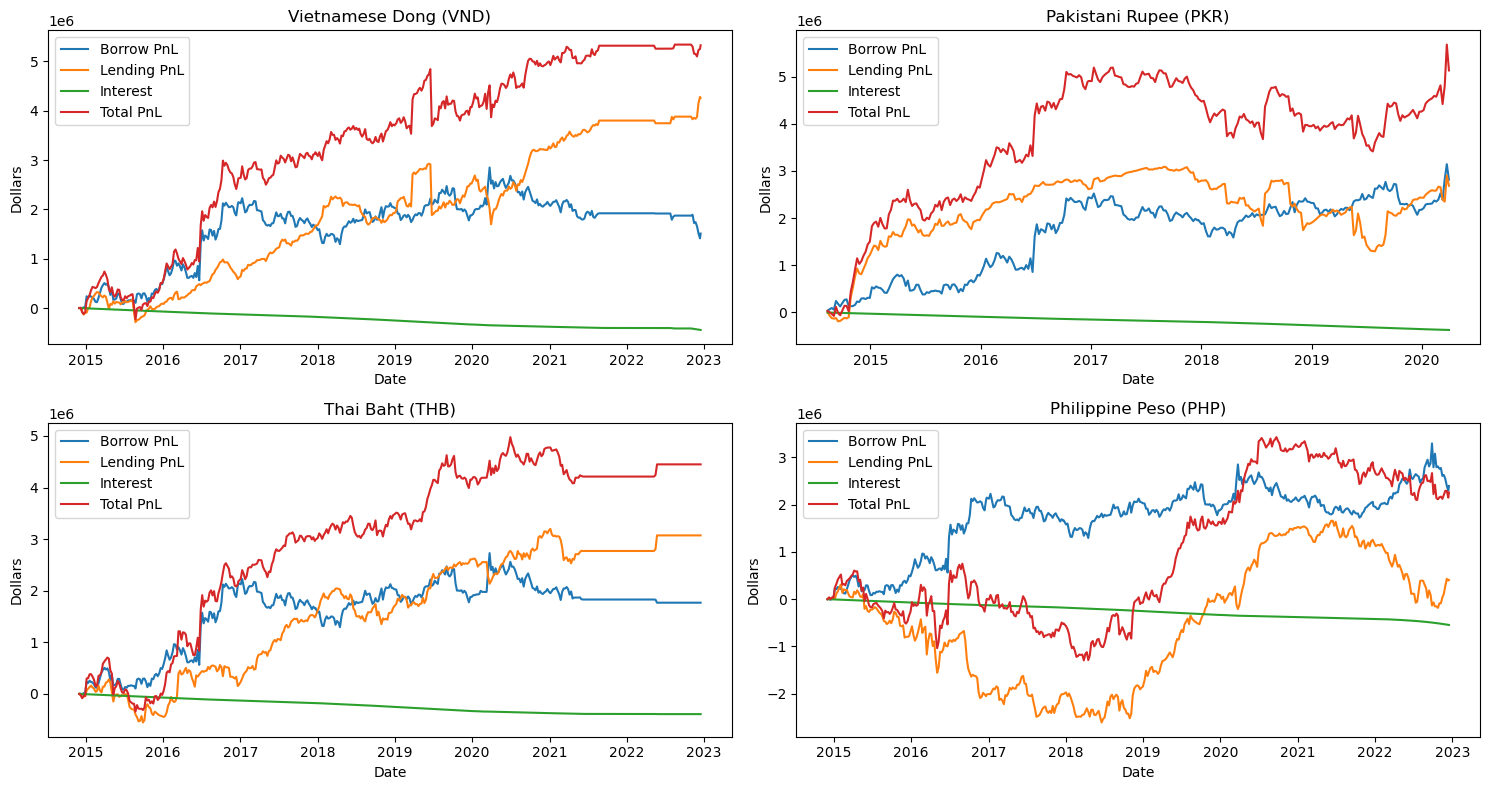

In [74]:
fig, axes = plt.subplots(2,2,figsize=(15,8))
labels = vnd.columns

axes[0,0].plot(vnd.cumsum(),label=labels)
axes[0,0].set_title('Vietnamese Dong (VND)')

axes[1,0].plot(thb.cumsum(),label=labels)
axes[1,0].set_title('Thai Baht (THB)')

axes[0,1].plot(pkr.cumsum(),label=labels)
axes[0,1].set_title('Pakistani Rupee (PKR)')

axes[1,1].plot(php.cumsum(),label=labels)
axes[1,1].set_title('Philippine Peso (PHP)')

for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Dollars')

plt.tight_layout()

In [75]:
total_profits = pd.concat([vnd['Total PnL'].cumsum().rename('VND'),pkr['Total PnL'].cumsum().rename('PKR'),thb['Total PnL'].cumsum().rename('THB'),php['Total PnL'].cumsum().rename('PHP')],axis=1)
total_profits.describe().loc[['max','min']]

,VND,PKR,THB,PHP
max,5.338554e+06,5.679965e+06,4.978247e+06,3.426115e+06
min,-2.291474e+05,-7.320627e+04,-3.428293e+05,-1.293329e+06


From initial observation, we see that PKR had the highest cumulative PnL while PHP had the largest cummulative loss. We see that at the end of the sample, VND performed the best. It is also important to note that our sample for PKR doesn't extend until 2022 as there is no data after. It would not be wise to extrapolate this data into the future as it wouldn't mean anything.

***

**3.3 PnL Components**

For thoroughness, we will also plot all the PnL components for each of the currencies with each other.

*3.3.1 Borrow PnL*

<AxesSubplot: title={'center': 'Borrow PnL Series'}, xlabel='Date', ylabel='Borrow PnL'>

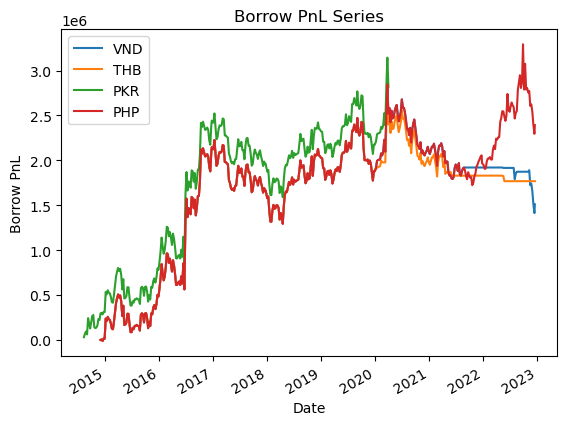

In [76]:
borrow_pnls = pd.concat([vnd['Borrow PnL'].to_frame('VND'), thb['Borrow PnL'].to_frame('THB'), pkr['Borrow PnL'].to_frame('PKR'), php['Borrow PnL'].to_frame('PHP')], axis=1).cumsum()
borrow_pnls.plot(xlabel='Date',ylabel='Borrow PnL',title='Borrow PnL Series')

*3.3.2 Lending PnL*

<AxesSubplot: title={'center': 'Lending PnL Series'}, xlabel='Date', ylabel='Lending PnL'>

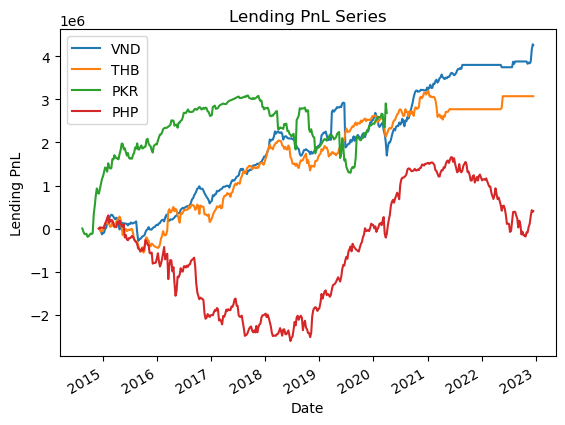

In [77]:
lend_pnls = pd.concat([vnd['Lending PnL'].to_frame('VND'), thb['Lending PnL'].to_frame('THB'), pkr['Lending PnL'].to_frame('PKR'), php['Lending PnL'].to_frame('PHP')], axis=1).cumsum()
lend_pnls.plot(xlabel='Date',ylabel='Lending PnL',title='Lending PnL Series')

*3.3.4 Total PnL*

<AxesSubplot: title={'center': 'Total PnL Series'}, xlabel='Date', ylabel='Total PnL'>

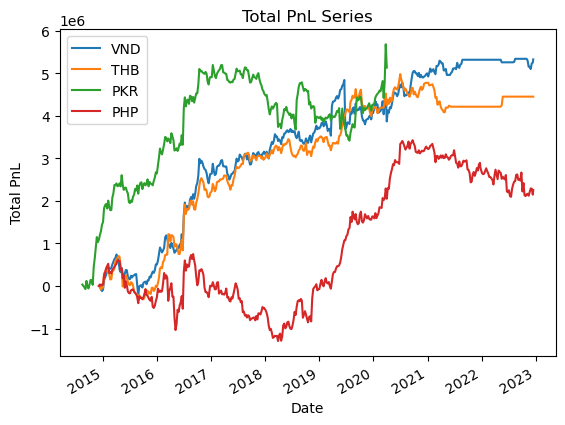

In [78]:
total_pnls = pd.concat([vnd['Total PnL'].to_frame('VND'), thb['Total PnL'].to_frame('THB'), pkr['Total PnL'].to_frame('PKR'), php['Total PnL'].to_frame('PHP')], axis=1).cumsum()
total_pnls.plot(xlabel='Date',ylabel='Total PnL',title='Total PnL Series')

***

**3.3 PnL Decompositions**

We will now show the PnL decompositions for the entire time period for the four different currencies. This gives a visual representation of the trade throughout the interval.

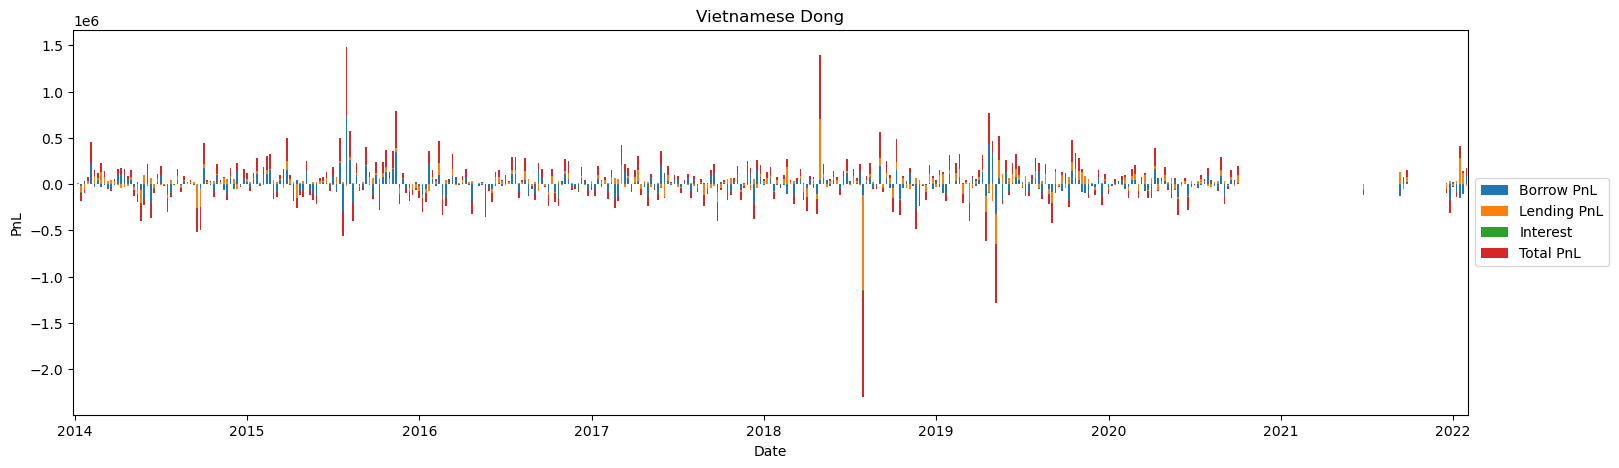

In [81]:
plot_decomposition(vnd,'Vietnamese Dong')

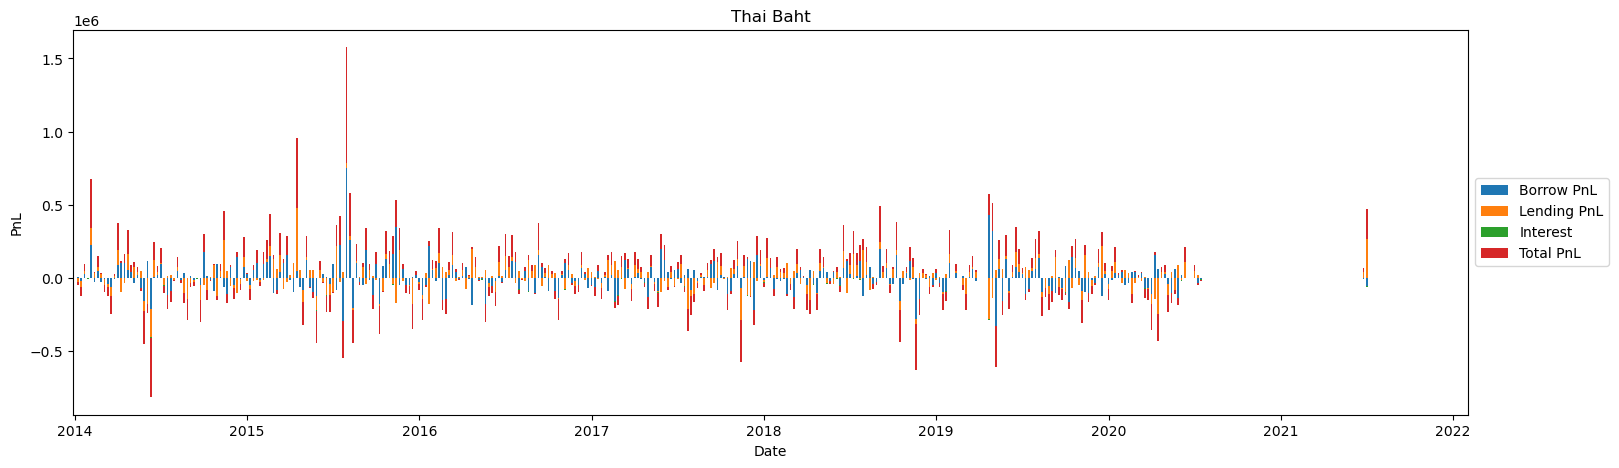

In [34]:
plot_decomposition(thb,'Thai Baht')

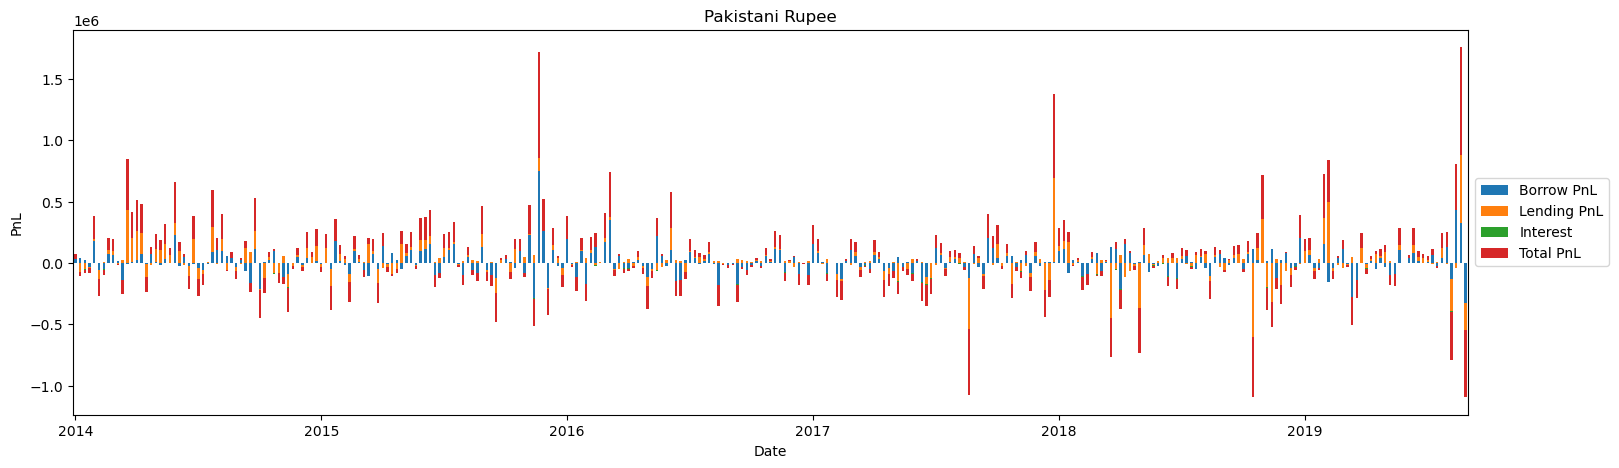

In [80]:
plot_decomposition(pkr,'Pakistani Rupee')

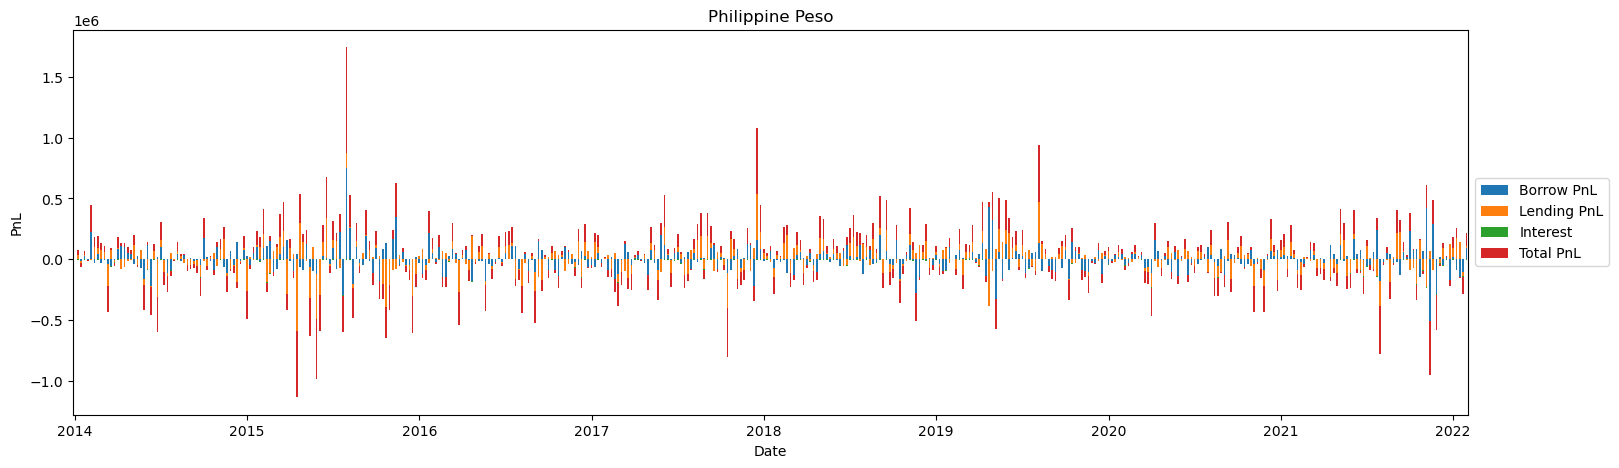

In [82]:
plot_decomposition(php,'Philippine Peso')

It is evident that we are not trading after 2020 in the Dong and the Baht. This is likely due to the interest rate differential of the 5Y swaps. For curiosity, let's see what happens when we trade regardless of the spread. 

***

**3.4 Removing the 5Y Swap Spread Condition**

We will utilize the **spread** condition in our simulate function.

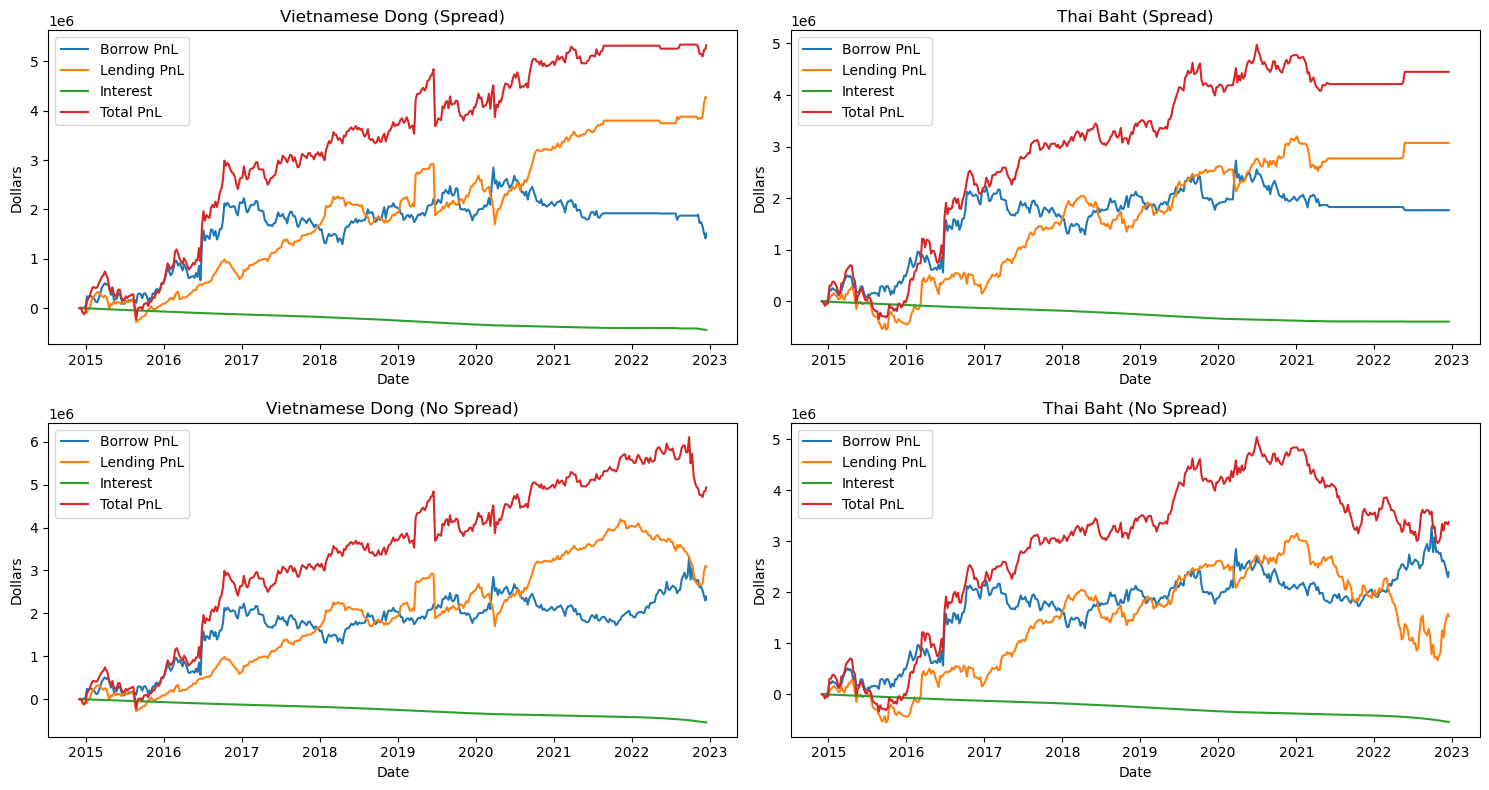

In [83]:
vnd_no_spread = simulate(VNDYIELD,'USDVND',spread=False)
thb_no_spread = simulate(THBYIELD,'USDTHB',spread=False)

fig, axes = plt.subplots(2,2,figsize=(15,8))
labels = vnd.columns

axes[0,0].plot(vnd.cumsum(),label=labels)
axes[0,0].set_title('Vietnamese Dong (Spread)')

axes[1,0].plot(vnd_no_spread.cumsum(),label=labels)
axes[1,0].set_title('Vietnamese Dong (No Spread)')

axes[0,1].plot(thb.cumsum(),label=labels)
axes[0,1].set_title('Thai Baht (Spread)')

axes[1,1].plot(thb_no_spread.cumsum(),label=labels)
axes[1,1].set_title('Thai Baht (No Spread)')

for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Dollars')

plt.tight_layout()

It is a lot more apparent why we should not trade if the 5Y swap rate of the lending currency is less than 50bp higher than the 5Y swap rate of the funding currency. We see that in both cases, we lose money if we ignore the spread and trade.

***

# 4 Analysis

We will now look at some more quantitative analysis of the performance of our FX carry trades.

**4.1 Helper Functions**

We define `roi`, `performance_metrics`, and `return_statistics` to evaluate some portfolio metrics. 

In [100]:
def roi(portfolio,initial_val=2_000_000):
    '''
    Calculates the ROI of a portfolio 

    Parameters:
        portfolio (DataFrame): DataFrame consisting of the value of the portfolio over time 
        initial_val (DataFrame): The initial value of a portfolio (default 2_000_000)

    Returns:
        rois (DataFrame): DataFrame consisting of the ROIs
    '''
    rois = pd.DataFrame(columns=portfolio.columns,index=['ROI'])
    for col in portfolio.columns:
        idx = portfolio[col].last_valid_index()
        rois[col] = portfolio[col].loc[idx] / initial_val 
    return rois

In [101]:
def performance_metrics(portfolio, annualization=52):
    '''
    Calculates common performance metrics for a portfolio

    Parameters:
        portfolio (DataFrame): DataFrame consisting of the value of the portfolio over time 
        annualization (int): All values are reported annualized, so annualization factor (default 52)

    Returns:
        metrics (DataFrame): DataFrame consisting of the portfolio metrics
    '''
    rets = portfolio.pct_change()
    metrics = pd.DataFrame(columns=rets.columns)
    metrics.loc['Mean Returns'] = rets.mean() * annualization
    metrics.loc['Volatility'] = rets.std() * np.sqrt(annualization)
    metrics.loc['Sharpe Ratio'] = metrics.loc['Mean Returns'] / metrics.loc['Volatility']

    metrics.loc['Max Return'] = rets.max()
    metrics.loc['Min Return'] = rets.min()
    metrics.loc['Win Rate'] = rets[rets >= 0].count() / (rets[rets >= 0].count() + rets[rets < 0].count())

    cum_returns = (rets + 1).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns / running_max) - 1 
    max_drawdown = drawdown.min()
    metrics.loc['Max Drawdown'] = max_drawdown
    metrics.loc['Calmar Ratio'] = np.sqrt(annualization) * rets.mean() / abs(max_drawdown)

    downside_rets = rets[rets < 0]
    downside_std = np.sqrt(annualization) * downside_rets.std()
    sortino_ratio = metrics.loc['Mean Returns'] / downside_std
    metrics.loc['Sortino Ratio'] = sortino_ratio
    
    return metrics

In [115]:
def return_statistics(portfolio):
    '''
    Calculates common risk tail statistics for a portfolio 

    Parameters:
        portfolio (DataFrame): DataFrame consisting of the value of the portfolio over time 

    Returns:
        metrics (DataFrame): DataFrame consisting of the tail statistics
    '''
    rets = portfolio.pct_change()
    metrics = pd.DataFrame(columns=rets.columns)
    metrics.loc['VaR (0.05)'] = rets.quantile(0.05)
    metrics.loc['CVaR (0.05)'] = rets[rets < rets.quantile(0.05)].mean()
    metrics.loc['Skewness'] = rets.skew()
    metrics.loc['Kurtosis'] = rets.kurt()
    return metrics

***

**4.1 Portfolio Graphs**

First, we will re-plot our profits but with a shift of \$2,000,000. This is our initial capital (without leverage), so we calculate our ROI with this.

<AxesSubplot: title={'center': 'Portfolio Value over Time'}, xlabel='Date', ylabel='Portfolio Value'>

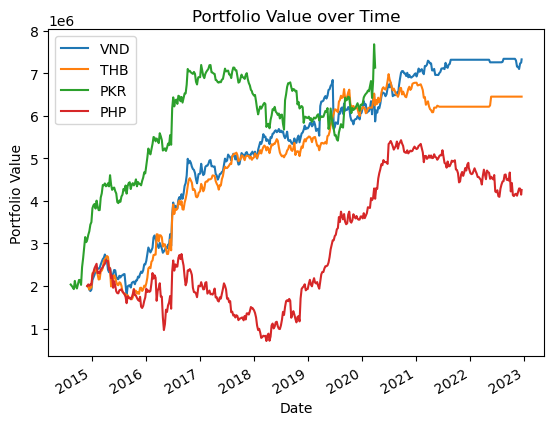

In [128]:
portfolios = total_pnls + 2_000_000
portfolios.plot(xlabel='Date',ylabel='Portfolio Value',title='Portfolio Value over Time')

In [129]:
roi(portfolios)

,VND,THB,PKR,PHP
ROI,3.662493,3.224827,3.566118,2.127462


We see that VND gave us the highest ROI, followed by PKR, THB, and PHP respectively.

***

**4.2 Return Statistics**

Let's now look at the performance metrics of our portfolio quantitatively.

In [130]:
performance_metrics(portfolios)

,VND,THB,PKR,PHP
Mean Returns,0.182418,0.167717,0.166969,0.219197
Volatility,0.209024,0.216958,0.188943,0.515676
Sharpe Ratio,0.872712,0.773037,0.883699,0.425068
Max Return,0.247711,0.277705,0.206663,0.593773
Min Return,-0.168498,-0.169909,-0.085817,-0.280217
Win Rate,0.640476,0.647619,0.685780,0.545238
Max Drawdown,-0.353677,-0.387265,-0.247146,-0.743107
Calmar Ratio,0.071525,0.060057,0.093687,0.040905
Sortino Ratio,1.089973,1.082704,1.392720,0.617391


We see the follow observations:
- Sharpe Ratios: PKR > VND > THB > PHP. We see that for the most part, they're close to 1, characteristic of Carry strategies.
- Max Drawdown: We see that PHP suffered the highest maximum drawdown while the other 3 currencies had drawdowns near to each other. 
- Max / Min Return: We see that PHP made the biggest portfolio gain in one trade but also lost the most. The other portfolios lost about 15% with one trade.
- Calmar Ratio: We see that the Calmar ratio is low for all four currencies, indicating that we are at risk to large drawdowns.
- Win Rate: We see that we have positive win rates for all the portfolios, characteristic of a carry trades.
- Sortino Ratio: A higher Sortino ratio is better as it as investors have higher gains for downside risk. We see that they have similar Sortino ratios.

In [131]:
return_statistics(portfolios)

,VND,THB,PKR,PHP
VaR (0.05),-0.029308,-0.033514,-0.028403,-0.094836
CVaR (0.05),-0.060525,-0.058187,-0.047969,-0.154942
Skewness,1.054642,2.354075,2.301290,1.827024
Kurtosis,17.764686,23.845280,14.318325,16.931921


When looking at tail statistics, we observe the following:
- VaR: We see that the VaR of VND, THB, and PKR are similar while PHP has a VaR of -0.09, indicating that is suffers huge losses.
- CVaR: Similarly, we see similar CVaRs with VND, THB, PKR. We see that PHP has a CVaR of -15%. 
- Kurtosis: We see extremely high kurtosis, which is characteristic of carry trades, showing tail risk.
- Skewness: Interestingly, we see a positive skew for these portfolios. Typically, we see negative skews for carry strategies. The positive skew could be explained by the fact that FX carry trades did extremely well in the last decade. There weren't too many 'big events' that could destroy a portfolio (besides COVID). Even then, we didn't trade in many of the periods during COVID and in the ones we did, we saw drawdown. We potentially need a larger sample size to see this negative skewness (i.e if we may see large negative skewness if we look at the 2008 Financial Crisis).

***


**4.3 Return Distributions**

Let's visually look at our return distributions.

In [133]:
returns = portfolios.pct_change()

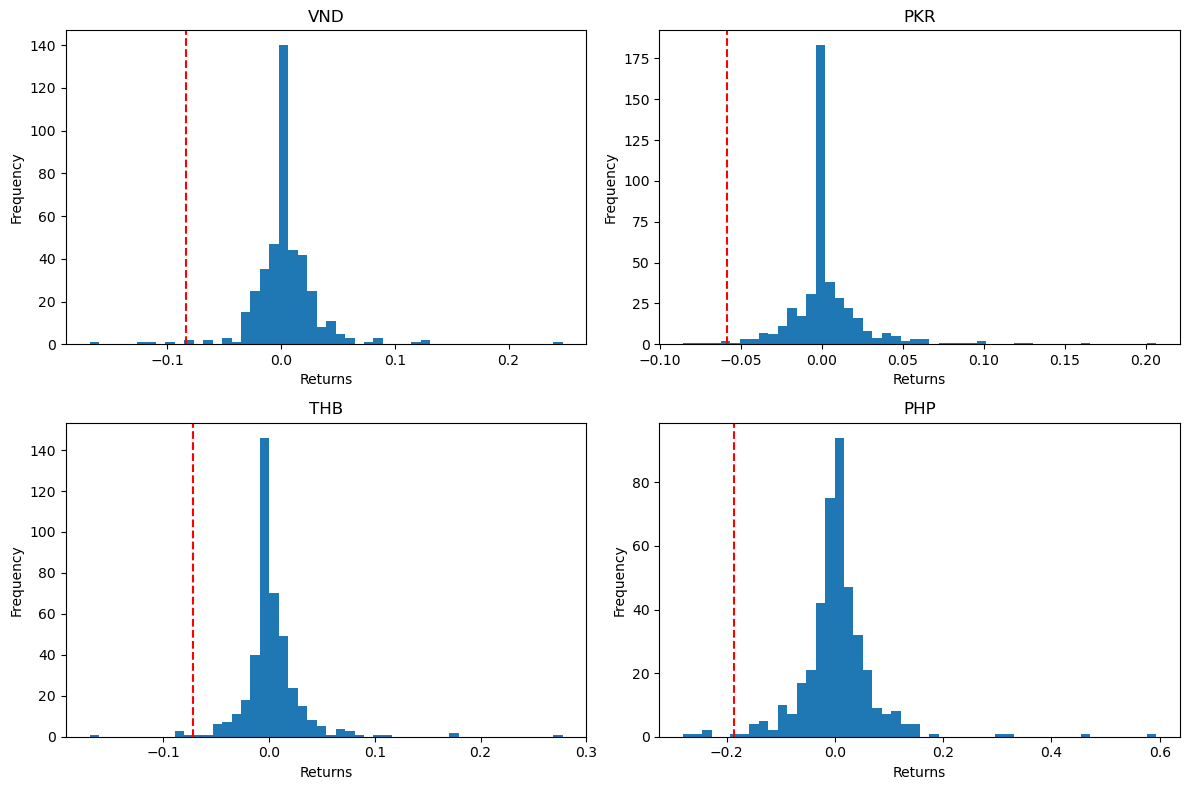

In [141]:
fig, axes = plt.subplots(2,2,figsize=(12,8))

axes[0,0].hist(returns['VND'],bins=50)
axes[0,0].axvline(x=returns['VND'].quantile(0.01),color='red',linestyle='--')
axes[0,0].set_title('VND')

axes[1,0].hist(returns['THB'],bins=50)
axes[1,0].axvline(x=returns['THB'].quantile(0.01),color='red',linestyle='--')
axes[1,0].set_title('THB')

axes[0,1].hist(returns['PKR'],bins=50)
axes[0,1].axvline(x=returns['PKR'].quantile(0.01),color='red',linestyle='--')
axes[0,1].set_title('PKR')

axes[1,1].hist(returns['PHP'],bins=50)
axes[1,1].axvline(x=returns['PHP'].quantile(0.01),color='red',linestyle='--')
axes[1,1].set_title('PHP')

for ax in axes.flatten():
    ax.set_xlabel('Returns')
    ax.set_ylabel('Frequency')

plt.tight_layout()

We can see why we have a large kurtosis. We see some returns that stray extremely far away from the mean. Here, the red line shows the bottom 1% of returns. We'll now give another perspective of these distributions by showing the distribution with boxplots.

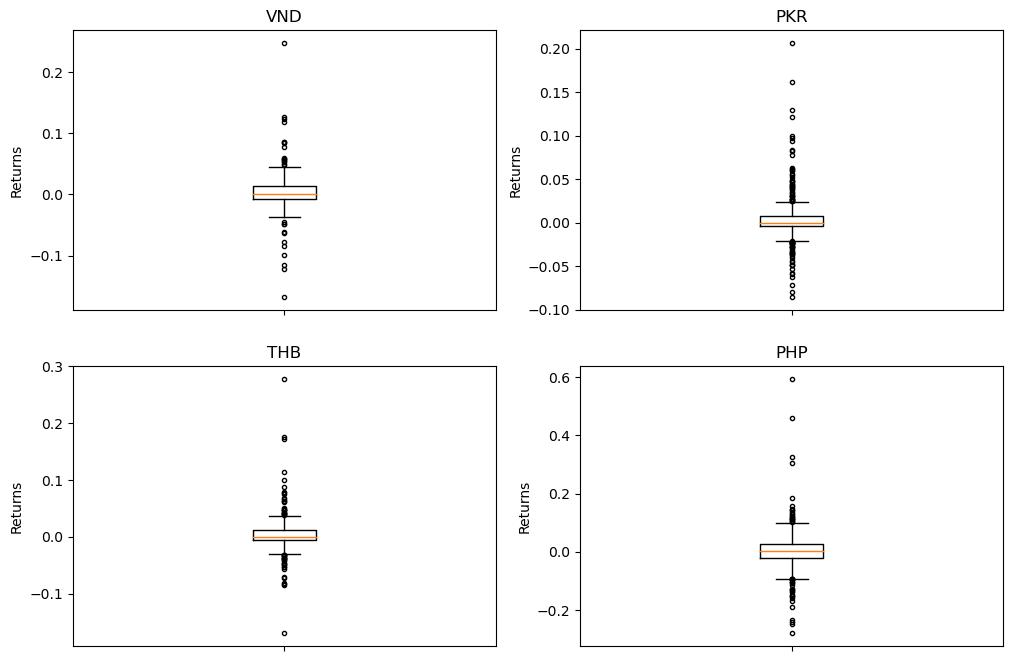

In [149]:
fig, axes = plt.subplots(2,2,figsize=(12,8))

axes[0,0].boxplot(returns['VND'].dropna(),flierprops={'markersize':3,'marker':'o'})
axes[0,0].set_title('VND')

axes[1,0].boxplot(returns['THB'].dropna(),flierprops={'markersize':3,'marker':'o'})
axes[1,0].set_title('THB')

axes[0,1].boxplot(returns['PKR'].dropna(),flierprops={'markersize':3,'marker':'o'})
axes[0,1].set_title('PKR')

axes[1,1].boxplot(returns['PHP'].dropna(),flierprops={'markersize':3,'marker':'o'})
axes[1,1].set_title('PHP')


for ax in axes.flatten():
    ax.set_ylabel('Returns')
    ax.set_xticklabels('')

***

**4.4 Correlation between strategies**

Let's see how correlated our strategies are. We will also look at the correlation of our strategies with a broad market factor. In this case, we will use the Mkt-RF factors from the Fama-French model. We expect these returns to have low correlations as the Fama-French predominantly deals with equities. We also expect equities to be risk-on when currencies are risk-off or vice versa. Nonetheless, we will first show these correlations. The Fama-French daily returns were obtained [here](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html), named **Fama/French 3 Factors [Daily]**. We converted this data into weekly returns starting on Wednesday.

In [151]:
factors = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
factors['Unnamed: 0'] = pd.to_datetime(factors['Unnamed: 0'], format='%Y%m%d')
factors = factors.rename(columns={'Unnamed: 0' : 'Date'}).set_index('Date')

factors = (factors/100) + 1
factors = factors.resample('W-TUE').apply(lambda x: x.prod()) - 1
factors = factors.loc[factors.index >= portfolios.pct_change().index[0]]

returns_wff = pd.concat([returns, factors[['Mkt-RF','RF']]],axis=1)

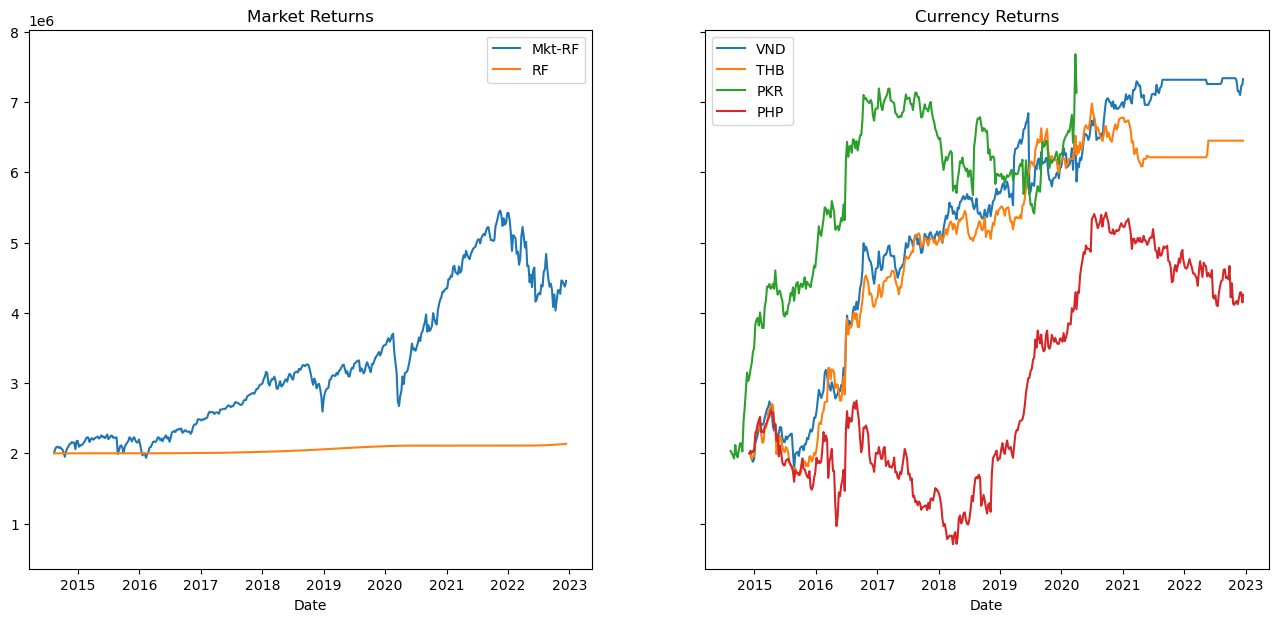

In [183]:
FF_port = 2_000_000 * (factors + 1).cumprod()
FF_port = FF_port.loc[(FF_port.index >= START_DATE) & (FF_port.index <= END_DATE)]

fig, axes = plt.subplots(1,2,figsize=(16,7),sharey=True,sharex=True)

axes[0].plot(FF_port[['Mkt-RF','RF']],label=['Mkt-RF','RF'])
axes[0].set_title('Market Returns')

axes[1].plot(portfolios,label=['VND','THB','PKR','PHP'])
axes[1].set_title('Currency Returns')

for ax in axes.flatten():
    ax.set_xlabel('Date')
    ax.legend()

We see that ROI wise, our strategy performs better for 3/4 of the currencies. This can be explained by the leverage we are using. Let's quickly look at portfolio metrics for the market factor.

In [185]:
performance_metrics(FF_port[['Mkt-RF','RF']])

,Mkt-RF,RF
Mean Returns,0.108692,0.007861
Volatility,0.165394,0.001309
Sharpe Ratio,0.657170,6.007118
Max Return,0.072208,0.000800
Min Return,-0.128952,0.000000
Win Rate,0.625287,1.000000
Max Drawdown,-0.277916,0.000000
Calmar Ratio,0.054235,inf
Sortino Ratio,0.732063,NaN


We see the following observations compared to the data earlier:
- Sharpe Ratio: It has a lower Sharpe compared to VND, THB, and PKR
- Max Drawdown: It has lower max drawdowns than all four currencies

Let's look at the correlation of these factors to our strategies.

<AxesSubplot: >

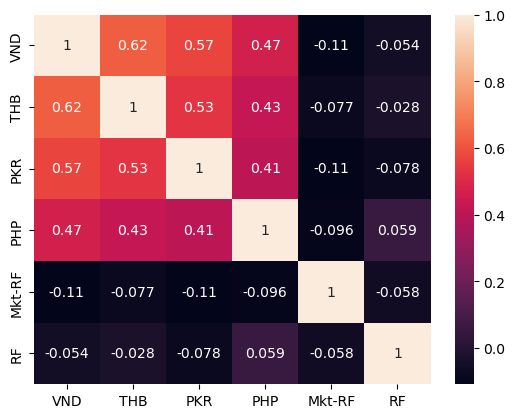

In [186]:
sns.heatmap(returns_wff.corr(),annot=True)

We see that the market factor has a very low correlation to our strategy. In fact, it is slightly negative, but the magnitude of the correlation is still extremely small. As expected, we also see the RF having a correlation of near zero. We see that our strategies are positively correlated to each other, though it isn't a strong correlation.

It is important to note that we examined the correlation of our strategies to factors commonly used in the equities market. We saw the correlation with the equities market and saw that they're relatively uncorrelated, though there is a very small negative correlation (if anything). Let's look at some potentially better assets to examine correlations to.

***

**4.5 Correlations with BND, DXY, and VIX**

Here, we examine correlations of our strategies with BND, DXY, and VIX. BND is the Vanguard Total Bond Market Index Fund ETF, DXY is the US Dollar Index, while VIX is the CBOE Volatility Index (which measures the *stock market's* expectation of volatility, though it still can be used as a fear indicator).

We obtain this data from *investing.com*. The data is linked below.

- [Vanguard Total Bond Market Index (BND)](https://www.investing.com/etfs/vanguard-total-bond-market)
- [US Dollar Index (DXY)](https://www.investing.com/indices/usdollar)
- [CBOE Volatility Index (VIX)](https://www.investing.com/indices/volatility-s-p-500)

In [232]:
def extract_data(filename,name):
    '''
    Extracts asset data from the local files 

    Parameters:
        filename (string): Filename of the asset
        name (string): Name for the DataFrame output 

    Returns:
        asset (DataFrame): DataFrame consisting of the resampled weekly returns
    '''
    asset = pd.read_csv(filename,index_col=0,parse_dates=True)[['Price']].sort_index(ascending=True).rename(columns={'Price':name})
    asset = asset.pct_change() + 1 
    asset = asset.resample('W-TUE').apply(lambda x: x.prod()) - 1 
    asset = asset.loc[(asset.index >= START_DATE) & (asset.index <= END_DATE)]
    return asset 

In [233]:
DXY = extract_data('US Dollar Index Historical Data.csv','DXY')
BND = extract_data('BND Historical Data.csv','BND')
VIX = extract_data('CBOE Volatility Index Historical Data.csv','VIX')

In [234]:
DXY_port = (1 + DXY).cumprod() 
BND_port = (1 + BND).cumprod()  
VIX_port = (1 + VIX).cumprod() 

asset_portfolios = pd.concat([DXY_port,BND_port,VIX_port],axis=1) * 2_000_000

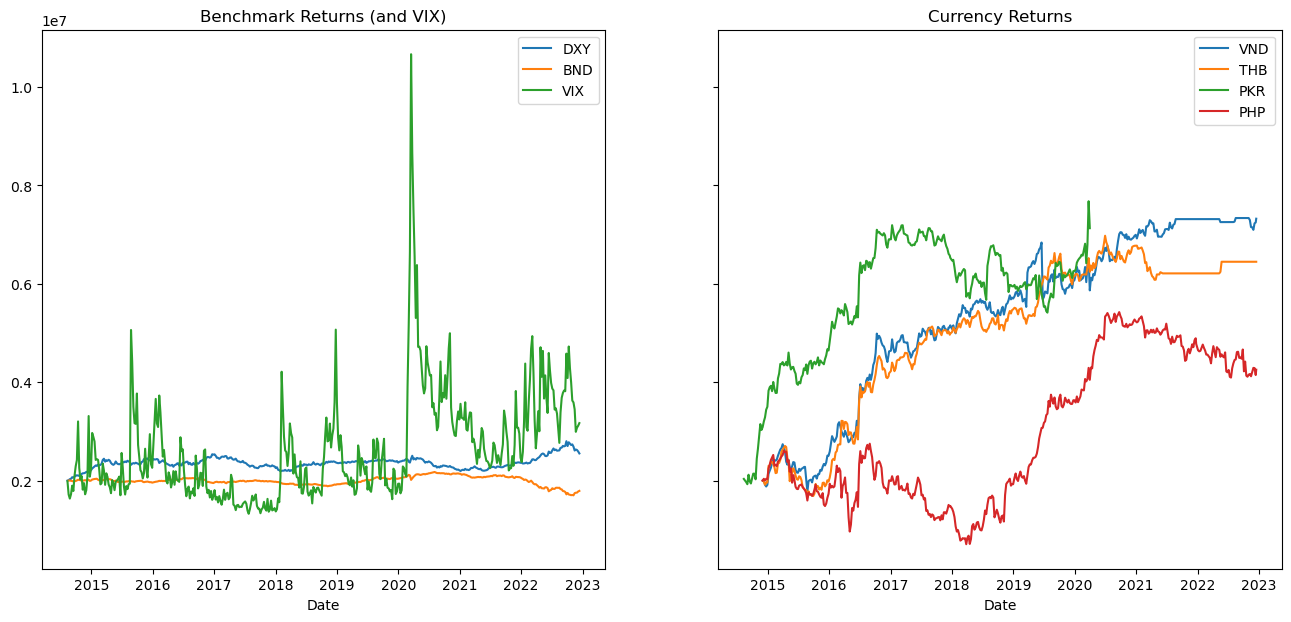

In [235]:
fig, axes = plt.subplots(1,2,figsize=(16,7),sharey=True,sharex=True)

axes[0].plot(asset_portfolios[['DXY','BND','VIX']],label=['DXY','BND','VIX'])
axes[0].set_title('Benchmark Returns (and VIX)')

axes[1].plot(portfolios,label=['VND','THB','PKR','PHP'])
axes[1].set_title('Currency Returns')

for ax in axes.flatten():
    ax.set_xlabel('Date')
    ax.legend()

We see that the returns of DXY and BND are extremely low. We also plotted the VIX for thoroughness and visualization.

In [236]:
performance_metrics(asset_portfolios)

,DXY,BND,VIX
Mean Returns,0.031568,-0.012267,0.718475
Volatility,0.069976,0.045097,1.273264
Sharpe Ratio,0.451123,-0.272012,0.564278
Max Return,0.035387,0.026022,1.612038
Min Return,-0.035404,-0.043192,-0.372083
Win Rate,0.528736,0.529954,0.452874
Max Drawdown,-0.136799,-0.218198,-0.793176
Calmar Ratio,0.032001,-0.007796,0.125615
Sortino Ratio,0.717133,-0.316445,1.367205


We see interesting statistics for the three benchmarks. In fact, we see that VIX actaully has the highest Sharpe Ratio. However, it is important to note that you cannot directly invest in DXY and VIX. These are just benchmarks. Now, let's plot the correlations between everything.

<AxesSubplot: >

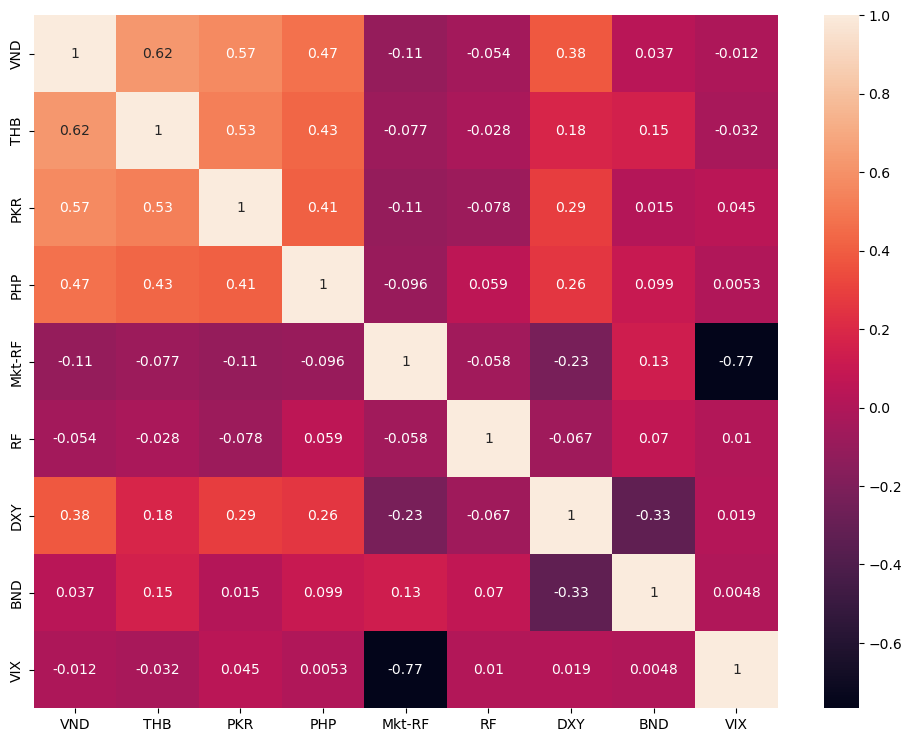

In [238]:
all_returns = pd.concat([returns, factors[['Mkt-RF','RF']], DXY, BND, VIX],axis=1)
plt.figure(figsize=(12,9))
sns.heatmap(all_returns.corr(), annot=True)

Some observations
- We see that the VIX has an extremely small correlation with our strategies
- DXY has the highest correlation to our strategies (slight positive correlation)
- BND almost has zero correlation with our strategies, though it has a slight positive correlation with THB

Logically, we can imagine that BND and DXY are two benchmarks we can use for our strategies. DXY is a common benchmark for FX rates and BND is a common benchmark for the global bond market. We will now perform a regression with BND and DXY as factors.

***

**4.6 Regressing on BND and DXY**

In [239]:
carry_returns = all_returns[['VND','THB','PKR','PHP']]
market_returns = all_returns[['DXY','BND']]

X = sm.add_constant(market_returns.dropna())

betas = pd.DataFrame(index=carry_returns.columns,columns=['const','DXY','BND'])
pvalues = pd.DataFrame(index=carry_returns.columns,columns=['const','DXY','BND'])
for col in carry_returns.columns:
    y_df = carry_returns[col].dropna()
    new_index = y_df.index.intersection(X.index)
    y_df = y_df.loc[new_index]
    X_df = X.loc[new_index]

    model = sm.OLS(y_df, X_df)
    results = model.fit()
    betas.loc[col] = results.params 
    pvalues.loc[col] = results.pvalues

In [240]:
multiindex = pd.MultiIndex.from_product([['betas','p-values'], betas.columns], names=['currency','predictor'])
combined = pd.concat([betas, pvalues], axis=1, keys=['betas', 'p-values'], names=['currency', 'predictor'])
combined = combined.reorder_levels([1,0], axis=1)
combined = combined.sort_index(axis=1)

combined

predictor       BND                 DXY              const          
currency      betas  p-values     betas p-values     betas  p-values
VND        0.855993  0.000103  1.326236      0.0  0.003011  0.022007
THB        1.149145  0.000002  0.816573      0.0  0.003059  0.033435
PKR        0.518986  0.011898  0.885406      0.0  0.002795  0.022314
PHP        2.354165  0.000034  2.390092      0.0  0.003473  0.303534

We see that our strategies have high betas to BND and DXY. We also see that these factors are significant with the extremely low p-values, meaning that we have exposure to BND and DXY as hypothesized.

***

**4.7 Downside Beta**

We saw previously that our strategies have high betas to DXY and BND. Let's now see the downside beta of our portfolios. For ease, we will calculate these unviariately.

In [241]:
def downside_beta(benchmark,carry):
    return market_returns[benchmark][market_returns[benchmark] < 0].cov(carry_returns[carry]) / market_returns[benchmark][market_returns[benchmark] < 0].var()

downside_betas = pd.DataFrame(columns=['VND','THB','PKR','PHP'],index=['DXY','BND'])
for benchmark in downside_betas.index:
    for carry in downside_betas.columns:
        downside_betas.loc[benchmark, carry] = downside_beta(benchmark, carry)

downside_betas

,VND,THB,PKR,PHP
DXY,1.001837,0.150315,0.524731,1.095669
BND,-0.310471,0.251551,-0.409076,0.918821


We see that we have positive downside betas with DXY while the results are a little less consistent for BND and our currency strategies. Downside beta indicates the association to a factor when that factor has negative returns for the day. We see the following observations:

- DXY: THB and PKR have lower associations when DXY has negative returns while VND and PHP have high betas.
- BND: We see that VND and PKR have negative associations when BND has negative returns while THB and PHP have positive associations. However, the association of THB is relatively low.

***

# 5 Conclusion

In this assignment, we created an FX carry trade by selling GBP and buying either Vietnamese Dong, Thai Baht, Pakistani Rupee, or Philippine Peso. First, we imported the data from Quandl and modified it such that all the data covered the same timeframe. We then examined the data and saw that GBP had lower interest rates while the East Asian currencies had higher interest rates. Some data was missing throughout and thus was filled in with linear interpolation. We entered each trade at the beginning of each week and exited at the end of each week, tracking the profits.

We saw that in terms of PnL, VND did the best, followed by PKR, then THB, and finally PHP. However, this was in terms of straight PnL and not standardized to anything. We also saw that we could make money from both lending and borrowing, depending on the interest rate. We decomposed our profit into our borrow PnL, lending PnL, and paid interest to have a better visual on our PnL throughout the simulations.

Afterwards, we looked at performance metrics for these portfolios based on our initial investment of $2 million. We could have used $10 million, but since we are using a leverage portfolio, we should be able to see higher returns and greater losses. We saw that our portfolios have Sharpes around 1, which is characteristic of carry trades. We also saw a positive win rate and high kurtosis, which are other common characteristics of carry trades. However, we saw a positive skewness. This could be attributed to the sample of time we observed. There was one major "world" event in the last decade (COVID) and we may need to go back further in time to see the single event that can give us a negative skewness (i.e the 2008 financial crisis). 

Next, we looked at the correlations of our strategies with common market benchmarks. Those being the equities market (Fama-French factors), the bond market (BND), and the dollar index (DXY). We saw that our strategies had low correlations to the market and bond market but a moderate correlation withi the dollar index. We also looked at the correlation of our market to VIX and saw a near zero correlation (very slightly negative). 

Afterwards, we deduced that BND and DXY are significant predictors as we are dealing with both bonds and FX rates, so these are logical predictors. We then regressed our returns on the returns of BND and DXY and saw betas of near 1 (or even greater) with near-zero (signficant) p-values. This indicates that we have high positive market exposure to the both BND and DXY.

Finally, we looked at the downside beta associated with these factors. However, we considered them in a univariate fashion. We saw that for DXY, our strategies all had positive downside betas, indicating that our strategies lose money when DXY loses money. However, the magnitude for THB and PKR is less than that of VND and PHP. We saw that the results for BND were more mixed. BND has negative downside betas with VND and PKR while positive downside betas with THB and PHP. However, the magnitudes are less than 1. PHP has the highest with 0.92.

In the future, we could look further into the FX carry trades by looking at more pairs. We only looked at Eastern Asian currencies, though we could also look into some South American currencies. We also looked at data in the last decade. It'd be interesting to see the data throughout 2000s, when equity returns were near 0 (from the DotCom crash and the 2008 financial crisis). It'd also be interesting to observe these strategies throughout the 1980s, when there was high inflation (similarly to now) to potentially see how these strategies would play out in the future. Finally, we could look into diversifying these carry trades to sees if we can improve performance. The correlations between the strategies themselves are relatively low and we could potentially gain some diversification effects, which could reduce our exposure to big market events.